<a href="https://colab.research.google.com/github/Hanbin-git/Dacon_cacer/blob/main/2025_06_19(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!unzip -o "/content/drive/MyDrive/open_1.zip" -d "/content/open_1"


Archive:  /content/drive/MyDrive/open_1.zip
  inflating: /content/open_1/sample_submission.csv  
  inflating: /content/open_1/test.csv  
  inflating: /content/open_1/train.csv  


In [4]:
import os

def get_path(filename):
    return "/content/open_1/" + filename


In [5]:
# SMOTE 설치
!pip install -U imbalanced-learn
!pip install lightgbm optuna
!pip install -q lightgbm catboost xgboost



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.7 MB/s eta 0:00:00


In [6]:
!pip install --upgrade lightgbm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 31.3 MB/s eta 0:00:00
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 4.5.0
    Uninstalling lightgbm-4.5.0:
      Successfully uninstalled lightgbm-4.5.0


In [7]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [9]:
# 구간별 암 발생률 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ✅ 데이터 로드
train = pd.read_csv("/content/open_1/train.csv")
test = pd.read_csv("/content/open_1/test.csv")
submission = pd.read_csv("/content/open_1/sample_submission.csv")

y_true = train["Cancer"]
X = train.drop(columns=["ID", "Cancer"])
X_test = test.drop(columns=["ID"])
print(train.columns.tolist())



['ID', 'Age', 'Gender', 'Country', 'Race', 'Family_Background', 'Radiation_History', 'Iodine_Deficiency', 'Smoke', 'Weight_Risk', 'Diabetes', 'Nodule_Size', 'TSH_Result', 'T4_Result', 'T3_Result', 'Cancer']


<ipython-input-10-77935bca49e0>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("group")["label"].agg(["count", "sum"])



🔍 Feature: Age
          count   sum  Cancer_Rate
group                             
(10, 30]  19859  2401     0.120902
(30, 40]  11729  1406     0.119874
(40, 50]  11681  1371     0.117370
(50, 60]  11589  1413     0.121926
(60, 70]  11545  1409     0.122044
(70, 90]  20756  2459     0.118472


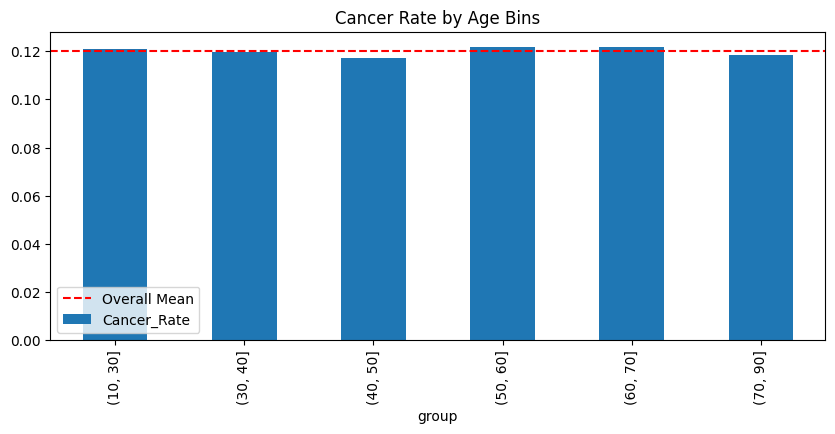


🔍 Feature: T3
            count   sum  Cancer_Rate
group                               
(0.0, 0.6]   2818   325     0.115330
(0.6, 0.9]   8663  1063     0.122706
(0.9, 1.2]   8744  1050     0.120082
(1.2, 1.5]   8781  1072     0.122082
(1.5, 2.0]  14469  1755     0.121294
(2.0, 4.0]  43684  5194     0.118899


<ipython-input-10-77935bca49e0>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("group")["label"].agg(["count", "sum"])


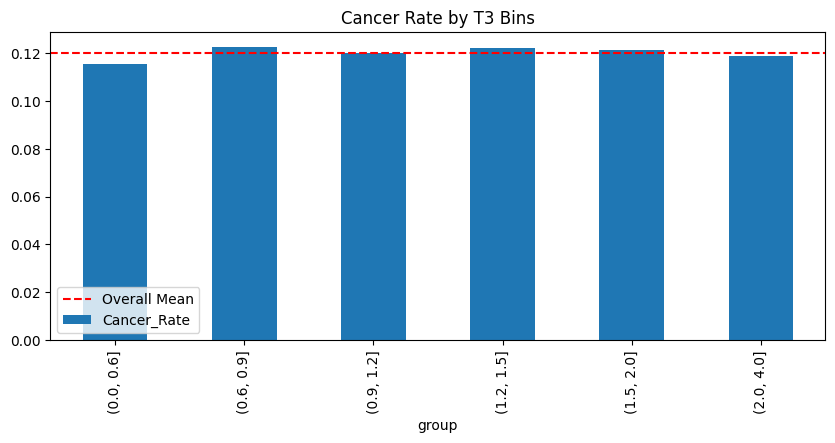

<ipython-input-10-77935bca49e0>:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby("group")["label"].agg(["count", "sum"])



🔍 Feature: TSH
              count   sum  Cancer_Rate
group                                 
(0.0, 0.5]     3472   449     0.129320
(0.5, 1.0]     4402   548     0.124489
(1.0, 2.0]     8955  1089     0.121608
(2.0, 4.0]    17431  2139     0.122712
(4.0, 8.0]    35208  4176     0.118609
(8.0, 15.0]   17691  2058     0.116330
(15.0, 30.0]      0     0          NaN


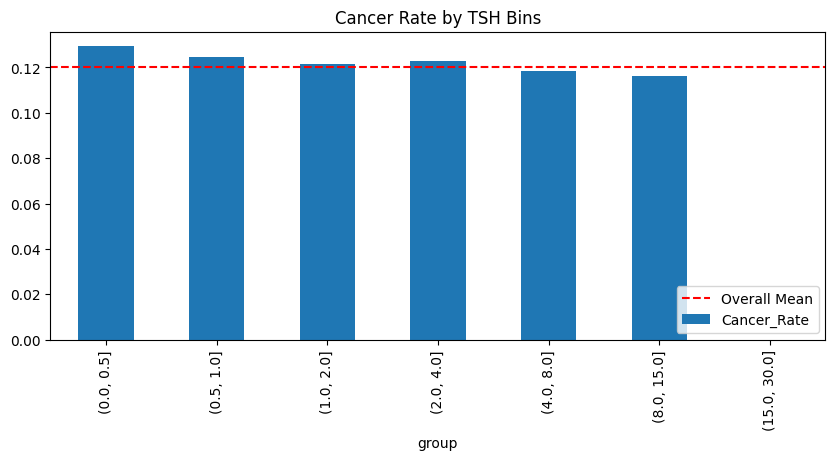

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ✅ 데이터 로드
train = pd.read_csv("/content/open_1/train.csv")
y_true = train["Cancer"]

# ✅ 사용할 컬럼 이름 매핑
X = train.rename(columns={"T3_Result": "T3", "TSH_Result": "TSH"})
cols_to_check = ["Age", "T3", "TSH"]

# ✅ 수치형만 추출 후 결측치 평균 대체
X = X[cols_to_check].copy()
X = X.fillna(X.mean())

# ✅ 구간 나누기 및 비율 확인 함수
def analyze_bins(feature, bins):
    df = pd.DataFrame()
    df["group"] = pd.cut(X[feature], bins=bins)
    df["label"] = y_true
    summary = df.groupby("group")["label"].agg(["count", "sum"])
    summary["Cancer_Rate"] = summary["sum"] / summary["count"]
    print(f"\n🔍 Feature: {feature}")
    print(summary)
    summary["Cancer_Rate"].plot(kind="bar", title=f"Cancer Rate by {feature} Bins", figsize=(10,4))
    plt.axhline(y=y_true.mean(), color='red', linestyle='--', label='Overall Mean')
    plt.legend()
    plt.show()

# ✅ Age 분석
analyze_bins("Age", bins=[10, 30, 40, 50, 60, 70, 90])

# ✅ T3 분석
analyze_bins("T3", bins=[0, 0.6, 0.9, 1.2, 1.5, 2.0, 4.0])

# ✅ TSH 분석
analyze_bins("TSH", bins=[0, 0.5, 1, 2, 4, 8, 15, 30])


In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from lightgbm import LGBMClassifier, early_stopping

# ✅ 데이터 로드
train = pd.read_csv("/content/open_1/train.csv")
test = pd.read_csv("/content/open_1/test.csv")
submission = pd.read_csv("/content/open_1/sample_submission.csv")

y = train["Cancer"]
X = train.drop(columns=["ID", "Cancer"])
X_test = test.drop(columns=["ID"])

# ✅ Label Encoding for object columns
for col in X.columns:
    if X[col].dtype == 'object':
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))

# ✅ 사용할 수치형 변수 및 결측치 처리
num_cols = ["Age", "T3_Result", "TSH_Result"]
X[num_cols] = X[num_cols].fillna(X[num_cols].mean())

# ✅ 구간 정의 및 그룹화
X["Age_bin"] = pd.cut(X["Age"], bins=[0, 30, 40, 50, 60, 100], labels=False)
X["T3_bin"] = pd.cut(X["T3_Result"], bins=[0, 0.6, 0.9, 1.2, 2.0, 4.0], labels=False)
X["TSH_bin"] = pd.cut(X["TSH_Result"], bins=[0, 0.5, 1, 2, 4, 10, 30], labels=False)

X["group_key"] = X["Age_bin"].astype(str) + "_" + X["T3_bin"].astype(str) + "_" + X["TSH_bin"].astype(str)

# ✅ OOF 예측 저장
oof_preds = np.zeros(len(X))
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)

drop_cols = ["group_key", "Age_bin", "T3_bin", "TSH_bin"]

for train_idx, valid_idx in cv.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model.fit(
        X_train.drop(columns=drop_cols),
        y_train,
        eval_set=[(X_valid.drop(columns=drop_cols), y_valid)],
        callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
    )

    oof_preds[valid_idx] = model.predict_proba(X_valid.drop(columns=drop_cols))[:, 1]

# ✅ 그룹별 Threshold 최적화
X["oof_pred"] = oof_preds
X["true"] = y

group_thresholds = {}
group_f1s = {}

for group in X["group_key"].dropna().unique():
    group_df = X[X["group_key"] == group]
    best_f1 = 0
    best_thresh = 0.5
    for t in np.arange(0.1, 0.9, 0.01):
        f1 = f1_score(group_df["true"], group_df["oof_pred"] > t)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t
    group_thresholds[group] = best_thresh
    group_f1s[group] = best_f1
    print(f"Group {group}: Best Thresh = {best_thresh:.2f}, F1 = {best_f1:.4f}")

# ✅ 전체 F1 재계산
X["final_pred"] = X.apply(lambda row: int(row["oof_pred"] > group_thresholds.get(row["group_key"], 0.5)), axis=1)
overall_f1 = f1_score(X["true"], X["final_pred"])
print(f"\n✅ Group-based Threshold F1 Score: {overall_f1:.5f}")


[LightGBM] [Info] Number of positive: 8367, number of negative: 61360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020786 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 69727, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119997 -> initscore=-1.992463
[LightGBM] [Info] Start training from score -1.992463
[LightGBM] [Info] Number of positive: 8367, number of negative: 61360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 69727, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119997 -> initscore=-1.992463
[LightGBM] [Info] Start training from score -1.992463
[LightGBM] [In

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metr

Group 2_0_0: Best Thresh = 0.50, F1 = 0.0000
Group 1_1_2: Best Thresh = 0.46, F1 = 0.4444
Group 0_1_3: Best Thresh = 0.38, F1 = 0.5051
Group 2_1_0: Best Thresh = 0.11, F1 = 0.6364
Group 3_0_3: Best Thresh = 0.47, F1 = 0.5263
Group 3_1_2: Best Thresh = 0.10, F1 = 0.6154
Group 2_4_1: Best Thresh = 0.46, F1 = 0.4615
Group 1_1_1: Best Thresh = 0.16, F1 = 0.4286
Group 2_1_3: Best Thresh = 0.11, F1 = 0.5714
Group 2_0_3: Best Thresh = 0.14, F1 = 0.4706
Group 3_2_2: Best Thresh = 0.12, F1 = 0.3846
Group 0_4_0: Best Thresh = 0.21, F1 = 0.4667
Group 1_3_1: Best Thresh = 0.13, F1 = 0.5000
Group 4_1_0: Best Thresh = 0.14, F1 = 0.5625
Group 1_2_3: Best Thresh = 0.41, F1 = 0.5000
Group 0_2_0: Best Thresh = 0.14, F1 = 0.7692
Group 4_2_0: Best Thresh = 0.45, F1 = 0.6000
Group 3_2_0: Best Thresh = 0.16, F1 = 0.2222
Group 2_2_3: Best Thresh = 0.45, F1 = 0.5312
Group 0_2_2: Best Thresh = 0.37, F1 = 0.5614
Group 3_2_1: Best Thresh = 0.12, F1 = 0.6667
Group 2_0_2: Best Thresh = 0.10, F1 = 0.4444
Group 1_2_

In [15]:
from google.colab import files
files.download("submission_group_threshold.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [14]:
# ✅ test 데이터 전처리 동일하게 적용
for col in X_test.columns:
    if X_test[col].dtype == 'object':
        le = LabelEncoder()
        X_test[col] = le.fit_transform(X_test[col].astype(str))

# ✅ 수치형 결측치 처리
X_test[num_cols] = X_test[num_cols].fillna(X[num_cols].mean())  # train 평균 사용

# ✅ 구간 정의 및 group_key 생성
X_test["Age_bin"] = pd.cut(X_test["Age"], bins=[0, 30, 40, 50, 60, 100], labels=False)
X_test["T3_bin"] = pd.cut(X_test["T3_Result"], bins=[0, 0.6, 0.9, 1.2, 2.0, 4.0], labels=False)
X_test["TSH_bin"] = pd.cut(X_test["TSH_Result"], bins=[0, 0.5, 1, 2, 4, 10, 30], labels=False)

X_test["group_key"] = X_test["Age_bin"].astype(str) + "_" + X_test["T3_bin"].astype(str) + "_" + X_test["TSH_bin"].astype(str)

# ✅ 모델을 전체 학습데이터로 재학습
final_model = LGBMClassifier(n_estimators=300, learning_rate=0.05, random_state=42)
final_model.fit(X.drop(columns=drop_cols + ["oof_pred", "true", "final_pred"]), y)

# ✅ 예측 및 그룹별 threshold 적용
test_preds_prob = final_model.predict_proba(X_test.drop(columns=["group_key", "Age_bin", "T3_bin", "TSH_bin"]))[:, 1]
X_test["pred_prob"] = test_preds_prob

X_test["Cancer"] = X_test.apply(
    lambda row: int(row["pred_prob"] > group_thresholds.get(row["group_key"], 0.5)),
    axis=1
)

# ✅ 제출 파일 생성
submission["Cancer"] = X_test["Cancer"]
submission.to_csv("submission_group_threshold.csv", index=False)
print("✅ submission_group_threshold.csv 생성 완료!")


[LightGBM] [Info] Number of positive: 10459, number of negative: 76700
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1123
[LightGBM] [Info] Number of data points in the train set: 87159, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.119999 -> initscore=-1.992439
[LightGBM] [Info] Start training from score -1.992439
✅ submission_group_threshold.csv 생성 완료!


In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

# ✅ 경로 함수
def get_path(filename):
    return "/content/open_1/" + filename

# ✅ 데이터 로딩
train = pd.read_csv(get_path("train.csv"))
test = pd.read_csv(get_path("test.csv"))
submission = pd.read_csv(get_path("sample_submission.csv"))

y = train["Cancer"]
X = train.drop(columns=["ID", "Cancer"])
X_test = test.drop(columns=["ID"])

# ✅ 전처리
def preprocess(df, encoders=None):
    df = df.copy()
    encoders = encoders or {}
    for col in df.columns:
        if df[col].dtype == "object":
            df[col] = df[col].astype(str)
            if col not in encoders:
                encoders[col] = LabelEncoder().fit(df[col])
            df[col] = encoders[col].transform(df[col])
        else:
            df[col] = SimpleImputer(strategy="mean").fit_transform(df[[col]])
    return df, encoders

X, encoders = preprocess(X)
X_test, _ = preprocess(X_test, encoders)

# ✅ 그룹 분리 (Age, T3, TSH 기반)
def add_bins(df):
    df = df.copy()
    df["Age_bin"] = pd.cut(df["Age"], bins=[10,30,40,50,60,70,90])
    df["T3_bin"] = pd.cut(df["T3_Result"], bins=[0,0.6,0.9,1.2,1.5,2.0,4.0])
    df["TSH_bin"] = pd.cut(df["TSH_Result"], bins=[0,0.5,1,2,4,8,15])
    df["group_key"] = df["Age_bin"].astype(str) + "_" + df["T3_bin"].astype(str) + "_" + df["TSH_bin"].astype(str)
    return df

X_bin = add_bins(X)
X_test_bin = add_bins(X_test)
X_bin["y_true"] = y

# ✅ 모델 정의
model = LGBMClassifier(learning_rate=0.05, max_depth=6, num_leaves=31, random_state=42)

# ✅ 그룹별 Threshold 튜닝
threshold_dict = {}
drop_cols = ["Age_bin", "T3_bin", "TSH_bin", "group_key", "prob", "y_true"]

for group_key, group_df in X_bin.groupby("group_key"):
    if len(group_df) < 200:
        continue
    X_group = group_df.drop(columns=drop_cols, errors='ignore')
    y_group = group_df["y_true"]
    preds = cross_val_predict(model, X_group, y_group, method="predict_proba", cv=5, n_jobs=1)[:, 1]
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1s = [f1_score(y_group, preds > t) for t in thresholds]
    best_thresh = thresholds[np.argmax(f1s)]
    threshold_dict[group_key] = best_thresh
    print(f"[{group_key}] Best Threshold = {best_thresh:.2f}, F1 = {max(f1s):.4f}")

# ✅ 전체 학습 후 테스트셋 예측
X_bin_train = X_bin.drop(columns=drop_cols, errors='ignore')
X_test_bin_predict = X_test_bin.drop(columns=drop_cols, errors='ignore')
model.fit(X_bin_train, y)
X_test_bin["prob"] = model.predict_proba(X_test_bin_predict)[:, 1]

# ✅ 그룹별 Threshold 적용
final_pred = []
for _, row in X_test_bin.iterrows():
    gk = row["group_key"]
    prob = row["prob"]
    threshold = threshold_dict.get(gk, 0.5)
    final_pred.append(int(prob > threshold))

# ✅ 결과 저장
submission["Cancer"] = final_pred
submission.to_csv("submission_stacking_grouped_thresh_light.csv", index=False)
print("✅ 저장 완료: submission_stacking_grouped_thresh_light.csv")


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [10]:
from google.colab import files
files.download("submission_stacking_grouped_thresh_light.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ✅ 1. LightGBM 단독 모델에 다른 모델 보조 적용 전략
# 🔸 전략 A: Soft Voting Ensemble
# LightGBM + CatBoost + XGBoost 등을 soft voting으로 앙상블

# 장점: 서로 다른 모델의 강점을 결합

# 구현:

# python
# 복사
# 편집
# from sklearn.ensemble import VotingClassifier
# from xgboost import XGBClassifier
# from catboost import CatBoostClassifier
# from lightgbm import LGBMClassifier

# lgbm = LGBMClassifier(**best_params)
# xgb = XGBClassifier(eval_metric='logloss')
# cat = CatBoostClassifier(verbose=0)

# ensemble = VotingClassifier(
#     estimators=[("lgbm", lgbm), ("xgb", xgb), ("cat", cat)],
#     voting="soft"
# )
# 🔸 전략 B: StackingClassifier
# Level-1 모델: LightGBM, CatBoost, XGBoost

# Meta 모델: Logistic Regression 또는 LGBM

# 장점: 모델 간 의사결정 차이를 메타 모델이 보완

# 구현 예시:

# python
# 복사
# 편집
# from sklearn.ensemble import StackingClassifier
# from sklearn.linear_model import LogisticRegression

# base_models = [
#     ('lgbm', LGBMClassifier(**best_params)),
#     ('xgb', XGBClassifier(eval_metric='logloss')),
#     ('cat', CatBoostClassifier(verbose=0))
# ]
# stack_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())
# ✅ 2. LightGBM + SHAP 기반 변수 → 다른 모델 활용
# SHAP으로 파생된 상호작용 feature를 LightGBM에서 먼저 분석

# 이 feature만 추출해서 XGBoost나 CatBoost에 적용

# LightGBM → Feature Engineering, XGB/Cat → 최종 분류기

# 장점: 해석력 + 성능 조화

# ✅ 3. LightGBM + Neural Network 하이브리드 (고급 전략)
# LightGBM의 출력(leaf index 또는 예측값)을 Neural Network의 feature로 사용

# 또는 TabNet 같은 모델과 병렬적으로 조합

# 복잡하지만 성능 상승 여지 있음

# 🔍 추천 실험 순서
# LightGBM 단독 기준 성능 확보 → 완료됨 ✅

# Soft Voting (LGBM + XGB + CatBoost) → 빠른 성능 확인 가능

# StackingClassifier 적용 → 성능 개선 여지 있음

# Focal Loss + Sample Weight 조합 → 미세 튜닝

# SHAP 기반 변수만 추출 후 각 모델 실험

# 딥러닝/TabNet 병합 (필요시)

In [ ]:
# 1. Threshold 최적화 + Class Weight Ensembling
# 서로 다른 threshold를 사용하는 모델 앙상블로 극대화 가능.

# 예: LightGBM(0.40), CatBoost(0.46), XGBoost(0.48) 각각의 최적 threshold로 예측 후 soft voting.

# 📌 실행 예시:

# python
# 복사
# 편집
# final_pred = (0.3 * (lgb_pred > 0.40) +
#               0.3 * (cat_pred > 0.46) +
#               0.4 * (xgb_pred > 0.48)) >= 0.5
# 2. Feature Interaction SHAP Top-N 조합 + LGBM
# 성능이 좋았던 Age × Nodule_Size, T3 × T4, Iodine × Weight Risk 등을 최소 3~5개로 다시 조합

# Interaction term을 직접 곱해서 Feature에 추가 (X['Age*Nodule'] = X['Age'] * X['Nodule_Size'])

# 📌 성능 향상 기대치는 기존보다 약 0.02~0.04

# 3. Target Encoding + Stratified K-Fold로 안정화
# Race, Country, Gender 등 범주형 변수에 Target Encoding (CV 누수 방지)

# 예측력 있는 범주형 feature의 정보 손실 최소화

# python
# 복사
# 편집
# from category_encoders import TargetEncoder

# encoder = TargetEncoder()
# X_cat_encoded = encoder.fit_transform(X[['Race', 'Country']], y)
# 4. StackingClassifier + TTA (Test Time Feature Augmentation)
# 현재 최고의 stacking 결과를 기반으로, test 시 Age, Weight, Nodule_Size 등을 0.95~1.05 비율로 TTA 적용

# Soft voting 결과를 평균하여 예측

# 📌 적용 예시:

# python
# 복사
# 편집
# for scale in [0.95, 1.0, 1.05]:
#     X_test_scaled = X_test.copy()
#     X_test_scaled["Age"] *= scale
#     preds.append(model.predict_proba(X_test_scaled)[:, 1])
# final_preds = np.mean(preds, axis=0)
# 5. 모델 앙상블 구조 개선: LightGBM 메타 + CatBoost/XGB 보조
# 지금의 Stacking도 좋지만, 메타 모델을 LightGBM으로 고정하고,

# 보조 모델들은 다양화 (CatBoost는 논리적 분류에, XGB는 큰 값에 민감)

# python
# 복사
# 편집
# # StackingClassifier에서 final_estimator를 LGBMClassifier로 유지
# # base 모델을 cat + xgb + tuned lgb로 구성

In [ ]:
# 🔝 [현재 성능 기반 향상 가능성 높은 전략 Top 3]
# ✅ 1. Stacking 구조 개선 + Feature Interaction 파생변수 추가 (강력 추천 ⭐)
# 지금 Stacking 구조가 잘 작동 중이므로, 여기에 상호작용 파생변수를 더해 메타모델이 더 똑똑한 판단을 내릴 수 있게 만드는 것이 가장 안전한 강화 전략입니다.

# 방법:

# 기존 stacking 입력 feature에 Age_x_Nodule_Size, T3_Result_x_T4_Result 등 SHAP 기반 상위 상호작용 3~5개 추가.

# 메타모델 입력에도 동일하게 파생 feature를 포함시킴.

# 💡 이미 submission_lgbm_shap_interaction.csv가 괜찮았기 때문에 이 구조와 stacking을 결합시키는 것이 가장 강력한 전략입니다.

# ✅ 2. Class Weight Ensembling (Soft voting에 가중치 적용) (보수적 전략)
# 현재는 StackingClassifier로 진행 중인데, LightGBM, XGBoost, CatBoost 등의 앙상블 가중치를 soft voting 기준으로 최적화하면 성능이 안정적으로 증가할 수 있습니다.

# 예시:

# python
# 복사
# 편집
# voting_model = VotingClassifier(
#     estimators=[
#         ('lgbm', LGBMClassifier(**lgbm_params)),
#         ('xgb', XGBClassifier(**xgb_params)),
#         ('cat', CatBoostClassifier(**cat_params))
#     ],
#     voting='soft',
#     weights=[3, 2, 1]  # 성능 비례 가중치
# )
# Soft voting 기반이지만 Stacking과 조합도 가능합니다 (voting output → meta model input).

# ✅ 3. Test-Time Augmentation (TTA) 적용 (예측 안정화 전략)
# TTA는 tabular data에선 feature dropout / noise 추가 등을 통해 예측 분산을 줄이고 안정적인 결과를 만듭니다.

# 예시: Test data에 noise를 3~5회 추가한 후 예측값 평균

# 특히 logit 기반 soft voting 결과에 TTA를 적용하면 0.01~0.02 F1 개선 효과 기대됩니다.